<a href="https://colab.research.google.com/github/jeffking1998/pytorch_RS_D2L/blob/main/RS_MF_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages and Load Dataset

* d2l 
The package of D2L book helps to implement the model easily. 

In [1]:
## show GPU's status
!nvidia-smi

## install compulsory modules
!pip install d2l

Tue Apr 26 10:14:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## import required packages 

import os
import pandas as pd
import torch
from d2l import torch as d2l ## ??

In [3]:
## download movielens-100k

##save
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

##save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


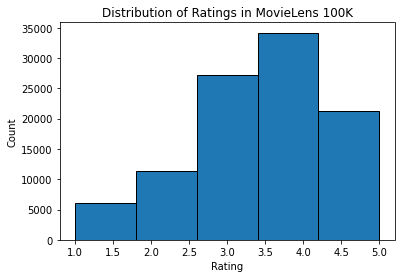

In [4]:
## Statistics & Visuaization of the MovieLens-100K

data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))


d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

In [5]:
## Split and Load Data into Tensor

def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in torch.rand(
            (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = torch.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)            # start from 0
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter


def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)

    class ML100KDataset(torch.utils.data.Dataset):
        def __init__(self, users, items, ratings):
            assert len(users) == len(items) == len(ratings)
            self.users = users
            self.items = items
            self.ratings = ratings

        def __getitem__(self, index):
            return (self.users[index], self.items[index],
                    self.ratings[index])

        def __len__(self):
            return len(self.users)

    train_set = ML100KDataset(train_u, train_i, train_r)
    test_set = ML100KDataset(test_u, test_i, test_r)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                      drop_last=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size)
    return num_users, num_items, train_iter, test_iter

## Build the Model 

In [6]:
# import packages 

import torch
from torch import nn


In [7]:
# # RMSE loss based on https://discuss.pytorch.org/t/rmse-loss-function/16540/4
# class RMSELoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.eps = eps
        
#     def forward(self, yhat, y):
#         loss = torch.sqrt(self.mse(yhat, y) + self.eps)
#         return loss 

# # convert tuple to tensor based on https://discuss.pytorch.org/t/convert-a-tuple-into-tensor/82964/3
# def tuple_to_tensor(tuple_tensors):
#     return torch.stack(tuple_tensors, dim=0)


In [8]:
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors)
        self.Q = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        # outputs = (P_u * Q_i).sum(axis=0) + torch.squeeze(b_u) + torch.squeeze(b_i)
        outputs = P_u @ Q_i + b_u + b_i
        return outputs

#### Hyperparameters

In [9]:
# devices = 'cuda:0'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

learning_rate = 0.002#1e-3
batch_size = 512
epochs = 50
test_ratio = 0.1
wd = 1e-5 



Using cuda device


#### SET loss_fun & optimizer



#### Optimizer Steps
* Functions: Train & Test  

In [16]:
import numpy as np 
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    l = 0 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for batch, values in enumerate(dataloader):
        # # Compute prediction and loss
        # batch = batch.to(device)
        # values = values.to(device)
        u_list, i_list, r_list = values 
        u_list, i_list, r_list = u_list.to(device), i_list.to(device), r_list.to(device)
        losses = []
        for u,i,r in zip(u_list, i_list, r_list):
            pred = model(u, i)
            # print(torch.squeeze(pred).shape)
            # print(r.float().shape)
            loss = loss_fn(torch.squeeze(pred), r.float()) #loss_fn(pred, r) 
            losses.append(loss)
            
        # Backpropagation
        optimizer.zero_grad()
        [loss.backward() for loss in losses]

        l += np.sqrt(np.mean([loss.item() for loss in losses]))
        optimizer.step()

        if (batch+1) % 10 == 0:
            print("loss: {:.2f}".format(l / (batch+1)))

In [11]:
def test_loop(dataloader, model, loss_fn):

    num_batches = len(dataloader)
    test_loss = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with torch.no_grad():
        for values in dataloader:
            losses = []
            u_list, i_list, r_list = values
            u_list, i_list, r_list = u_list.to(device), i_list.to(device), r_list.to(device)
            tmp_loss = 0
            for u,i,r in zip(u_list, i_list, r_list):
                pred = model(u, i)
                losses.append(loss_fn(torch.squeeze(pred), r.float()).item())
            tmp_loss = np.mean(losses)
            test_loss.append( np.sqrt(tmp_loss) )

    test_loss_v  = np.mean(test_loss)
    print(f"Test Avg loss: {test_loss_v:>8f} \n")

## Perform the MF model

In [12]:
# ## DO: get the train & test iter tensors 

num_users, num_items, train_iter, test_iter = split_and_load_ml100k(
    test_ratio=test_ratio, batch_size=batch_size)

In [13]:
# for i, data in enumerate(train_iter):
#     print("i: ", i)
#     print('device:', device)
#     u,i,r = data 
#     # print("data:", data.to(device))
#     print("u:", u.to(device))
#     print("i:", i.to(device))
#     print("r:", r.to(device))
#     break

In [18]:
## init the model, and feed the train & test dataset into GPU 

# train_iter.to(device)
# test_iter.to(device)
model = MF(30, num_users, num_items).to(device)

# Initialize the loss function
loss_fn = nn.MSELoss()


# define the optimizer 
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_iter, model, loss_fn, optimizer)
    test_loop(test_iter, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 6.70
loss: 6.65
loss: 6.61
loss: 6.62
loss: 6.60
loss: 6.58
loss: 6.57
loss: 6.55
loss: 6.54
loss: 6.52
loss: 6.51
loss: 6.50
loss: 6.48
loss: 6.46
loss: 6.45
loss: 6.43
loss: 6.42
loss: 6.41
loss: 6.40
Test Avg loss: 5.880799 

Epoch 2
-------------------------------
loss: 6.03
loss: 6.01
loss: 6.01
loss: 5.99
loss: 5.96
loss: 5.95
loss: 5.92
loss: 5.90
loss: 5.89
loss: 5.87
loss: 5.85
loss: 5.84
loss: 5.83
loss: 5.81
loss: 5.80
loss: 5.78
loss: 5.77
loss: 5.76
loss: 5.75
Test Avg loss: 5.492755 

Epoch 3
-------------------------------
loss: 5.32
loss: 5.30
loss: 5.34
loss: 5.33
loss: 5.31
loss: 5.31
loss: 5.32
loss: 5.30
loss: 5.29
loss: 5.28
loss: 5.26
loss: 5.25
loss: 5.24
loss: 5.23
loss: 5.22
loss: 5.21
loss: 5.21
loss: 5.19
loss: 5.18
Test Avg loss: 5.146789 

Epoch 4
-------------------------------
loss: 4.88
loss: 4.90
loss: 4.86
loss: 4.84
loss: 4.84
loss: 4.84
loss: 4.83
loss: 4.81
loss: 4.79
loss: 4.78
loss: 4.76
loss: 4.75
los